#Import Libraries and Data Cleaning

In [ ]:
import os
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.inspection import permutation_importance

sns.set(style="whitegrid")

from sklearn.metrics import accuracy_score,f1_score, confusion_matrix, precision_score, recall_score, roc_auc_score

In [ ]:
df = pd.read_csv("Lead_school.csv")
df.columns = df.columns.str.replace('\xa0', ' ').str.strip()
df.columns

Index(['Compliance Period', 'School District', 'School', 'County',
       'Type of Organization', 'BEDS Code', 'School Website',
       'Number of Outlets that Require Sampling',
       'Number of Outlets Sampled 2023', 'Number of Outlets Sampled 2024',
       'Number of Outlets Sampled 2025', 'Sampling Complete',
       'Number of Outlets, Result ≤ 5 ppb',
       'Number of Outlets, Result > 5 ppb', 'All Results Received',
       'Out of Service or Addressed', 'Remediation Status', 'School Street',
       'School City', 'School State', 'School ZIP Code', 'Date Survey Updated',
       'County Location', 'Location', 'Cleaned_school_name', 'PS_No',
       'Free_lunch', 'Total_students', 'Ratio_free', 'Student_teacher_ratio',
       'American Indian/Alaska Native', 'Asian', 'Black', 'Hispanic', 'White',
       'Native Hawaiian/Pacific Islander', 'Two or More Races'],
      dtype='object')

In [ ]:
os.listdir('.')

['.config', 'Lead_school.csv', 'sample_data']

In [ ]:
df_copied = df.copy()

In [ ]:
df_copied.columns = df_copied.columns.str.replace('\xa0', ' ', regex=False)


In [ ]:
col_to_drop = ['School Street','Cleaned_school_name','PS_No','Location','Remediation Status',
               'Type of Organization','Compliance Period','School Website','Date Survey Updated','BEDS Code',
               'County Location','All Results Received','Out of Service or Addressed',
               'School State','Number of Outlets that Require Sampling','Number of Outlets Sampled 2023',
               'Number of Outlets Sampled 2024','Number of Outlets Sampled 2025', 'Sampling Complete','School ZIP Code','Free_lunch','Total_students']

In [ ]:
df_copied.drop(columns=col_to_drop,inplace=True)

In [ ]:
df_copied = df_copied.rename(columns={'Number of Outlets, Result ≤ 5 ppb' : 'num_lte_5ppb', 'Number of Outlets, Result > 5 ppb': 'num_gt_5ppb'})

In [ ]:
df_copied.columns = df_copied.columns.str.replace(' ', '_').str.strip()

In [ ]:
df_copied.columns

Index(['School_District', 'School', 'County', 'num_lte_5ppb', 'num_gt_5ppb',
       'School_City', 'Ratio_free', 'Student_teacher_ratio',
       'American_Indian/Alaska_Native', 'Asian', 'Black', 'Hispanic', 'White',
       'Native_Hawaiian/Pacific_Islander', 'Two_or_More_Races'],
      dtype='object')

### Comment

Some of the entries in 'Number of Outlets, Result ≤ 5 ppb' are negative. So, we set those rows to be NaN and also set the corresponding entries in 'Number of Outlets, Result > 5 ppb' to be  NaN

In [ ]:
mask = df_copied['num_lte_5ppb'] < 0
df_copied.loc[mask,['num_lte_5ppb','num_gt_5ppb']]= np.nan

In [ ]:
df_copied.describe()

,num_lte_5ppb,num_gt_5ppb,Ratio_free,Student_teacher_ratio,American_Indian/Alaska_Native,Asian,Black,Hispanic,White,Native_Hawaiian/Pacific_Islander,Two_or_More_Races
count,2922.000000,2922.000000,2678.000000,2757.000000,2678.000000,2678.000000,2678.000000,2678.000000,2678.000000,2678.000000,2678.000000
mean,51.075975,3.052704,0.600774,11.894331,0.012645,0.108741,0.149909,0.315161,0.376164,0.002722,0.034400
std,37.062403,6.190900,0.274006,2.909065,0.051672,0.164491,0.189122,0.257194,0.333575,0.006071,0.033699
min,0.000000,0.000000,0.008219,2.130000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,22.000000,0.000000,0.382986,10.070000,0.000000,0.009804,0.017668,0.100000,0.044496,0.000000,0.009060
50%,44.000000,0.000000,0.598274,11.690000,0.003229,0.036682,0.065478,0.225691,0.302326,0.000000,0.024781
75%,71.000000,4.000000,0.862042,13.650000,0.007407,0.133333,0.208381,0.502420,0.678366,0.003158,0.049565
max,269.000000,100.000000,1.000000,57.110000,0.991736,0.920495,0.903846,0.997143,1.000000,0.141473,0.213333


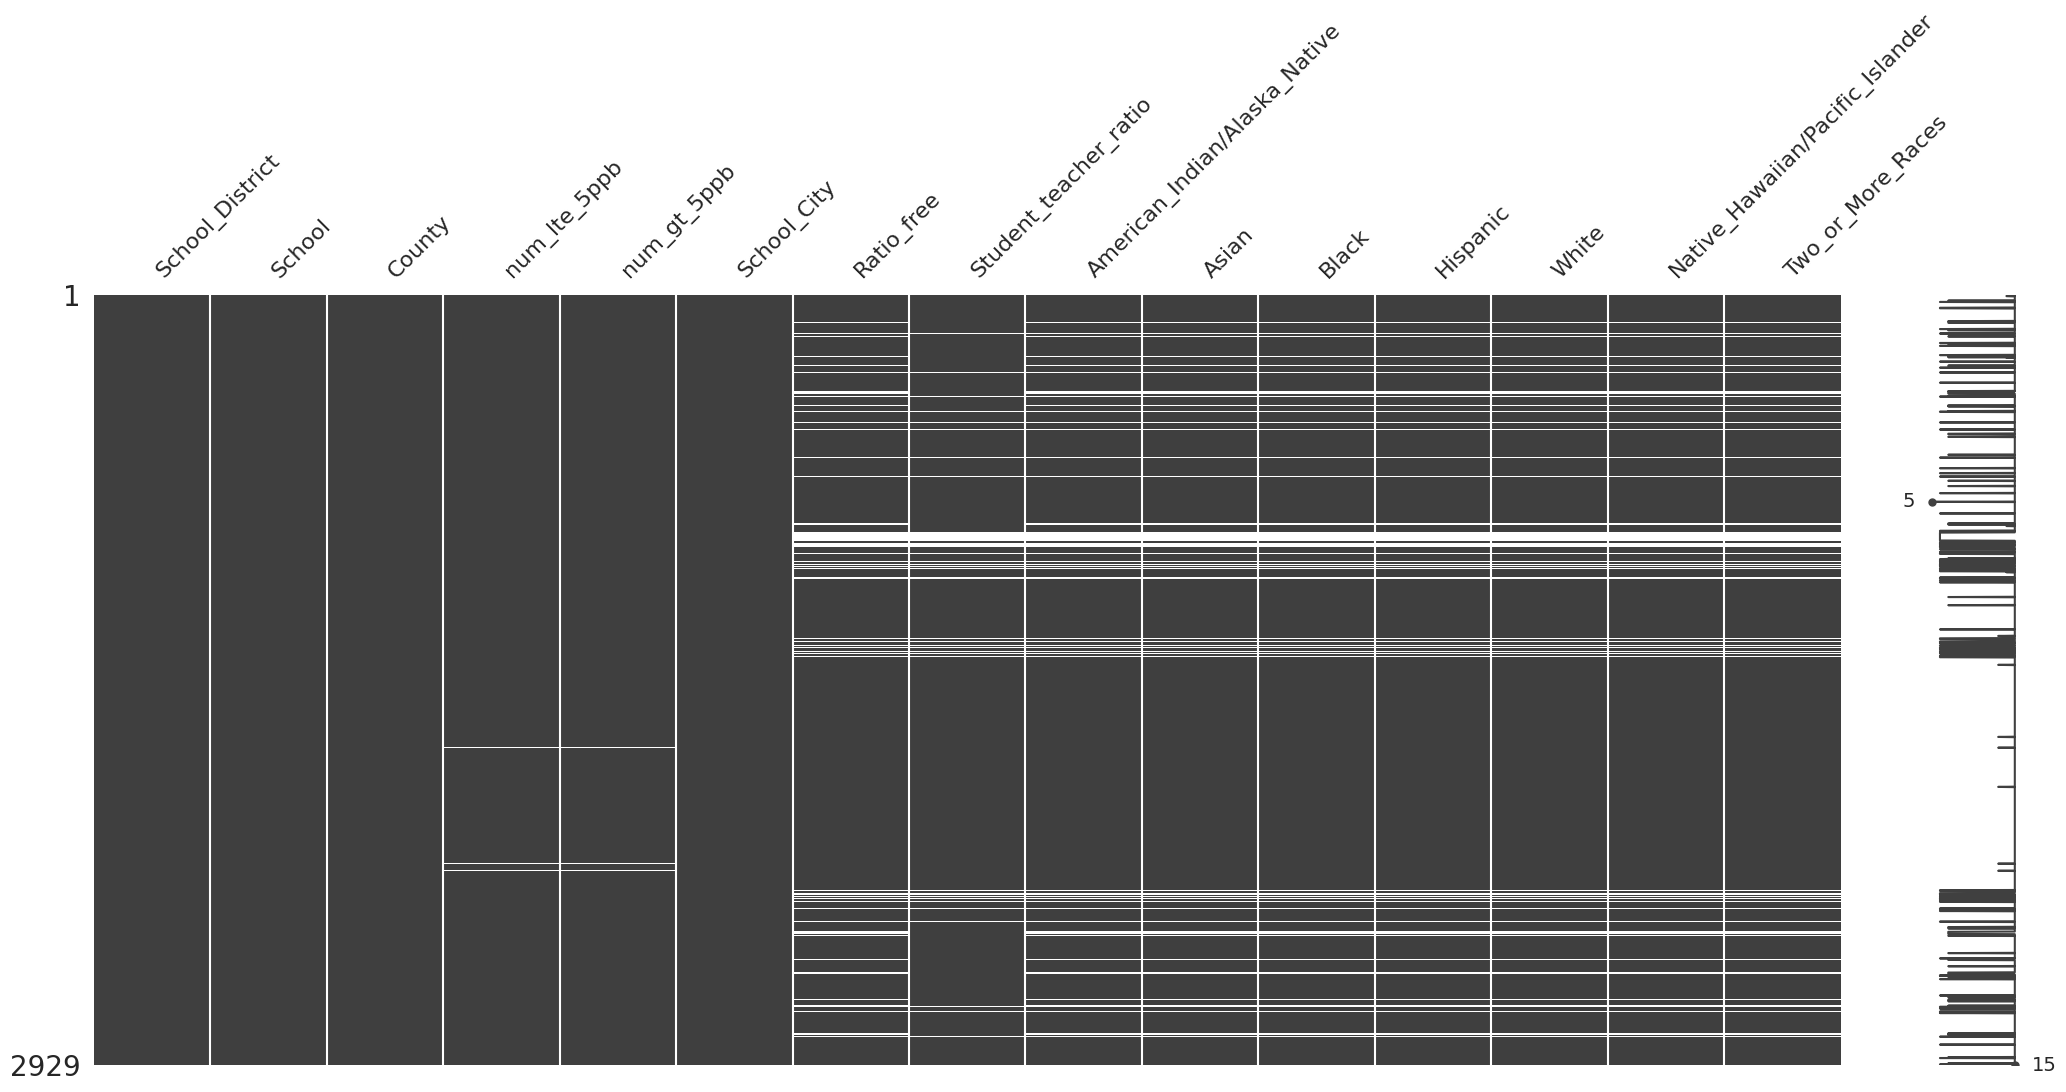

In [ ]:
msno.matrix(df_copied)
plt.show()

In [ ]:
missing_data = df_copied.isna().mean().sort_values(ascending=False)*100

In [ ]:
missing_data

,0
Ratio_free,8.569478
White,8.569478
Native_Hawaiian/Pacific_Islander,8.569478
Hispanic,8.569478
Black,8.569478
Asian,8.569478
American_Indian/Alaska_Native,8.569478
Two_or_More_Races,8.569478
Student_teacher_ratio,5.872311
num_gt_5ppb,0.238989


#  Correlation across Variables

In [ ]:
numeric_cols = df_copied.select_dtypes(include=[np.number]).columns
categorical_cols = df_copied.select_dtypes(include=['object', 'category']).columns


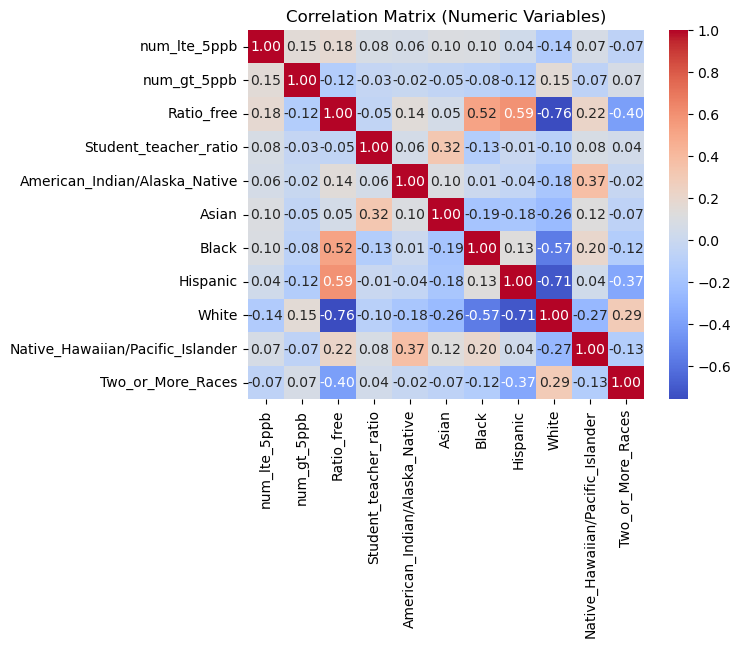

In [ ]:
plt.Figure(figsize=(7,5))
corr = df_copied[numeric_cols].corr()
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Correlation Matrix (Numeric Variables)")
plt.show()

We see that  there is strong negative correlation between 'White' and 'Ratio_free' , 'White' and 'Hispanic'. Hence we calculate Variance Inflation Factor (VIF) to check multicollinearity

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor


X_subset = df_copied[['White', 'Ratio_free', 'Hispanic']].dropna()

vif_data = pd.DataFrame()
vif_data['feature'] = X_subset.columns
vif_data['VIF'] = [variance_inflation_factor(X_subset.values, i) for i in range(X_subset.shape[1])]

print(vif_data)


      feature       VIF
0       White  1.393300
1  Ratio_free  4.911209
2    Hispanic  4.144269


### Adding a new column to the dataframe


We note that the number of outlets having lead > 5 ppb is highly skewed. Hence, we have decided to make a model which can tell whether a given school will have an outlet with lead > 5 ppb based uon the feature columns - a classification problem. Therefore, we add a new column 'target_col' which is 1 if the school has atleast 1 outlet which had lead > 5 ppb or else 0

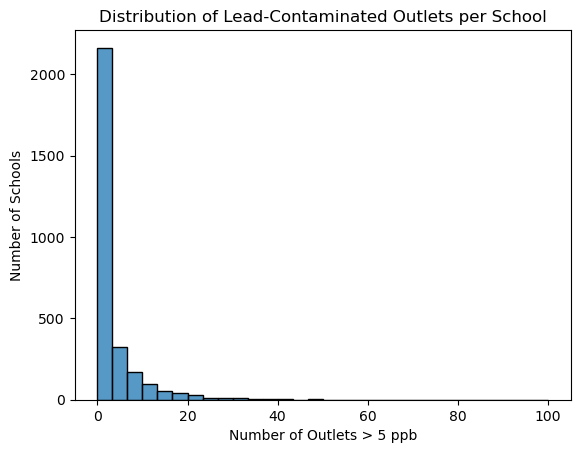

In [ ]:
sns.histplot(df_copied['num_gt_5ppb'], bins=30, kde=False)
plt.xlabel('Number of Outlets > 5 ppb')
plt.ylabel('Number of Schools')
plt.title('Distribution of Lead-Contaminated Outlets per School')
plt.show()

In [ ]:
df_copied['target_col'] = (df_copied['num_gt_5ppb']>0).astype(int)

In [ ]:
corr_target_var = df_copied[numeric_cols].corrwith(df_copied['target_col']).sort_values(key=abs, ascending=False)
corr_target_var

num_gt_5ppb                         0.519895
White                               0.227605
Ratio_free                         -0.215126
Black                              -0.139422
Hispanic                           -0.131042
Native_Hawaiian/Pacific_Islander   -0.123333
Two_or_More_Races                   0.102166
Student_teacher_ratio              -0.098641
Asian                              -0.091142
American_Indian/Alaska_Native      -0.069182
num_lte_5ppb                       -0.055604
dtype: float64

### Balanced or Imbalanced
We see that the target variable is relatively balanced

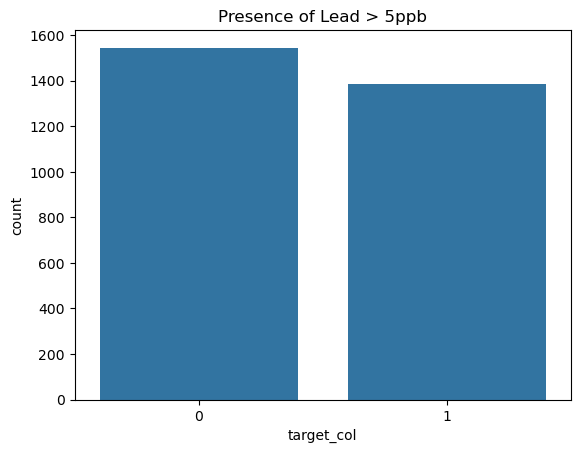

In [ ]:
sns.countplot(x='target_col', data=df_copied)
plt.title('Presence of Lead > 5ppb')
plt.show()


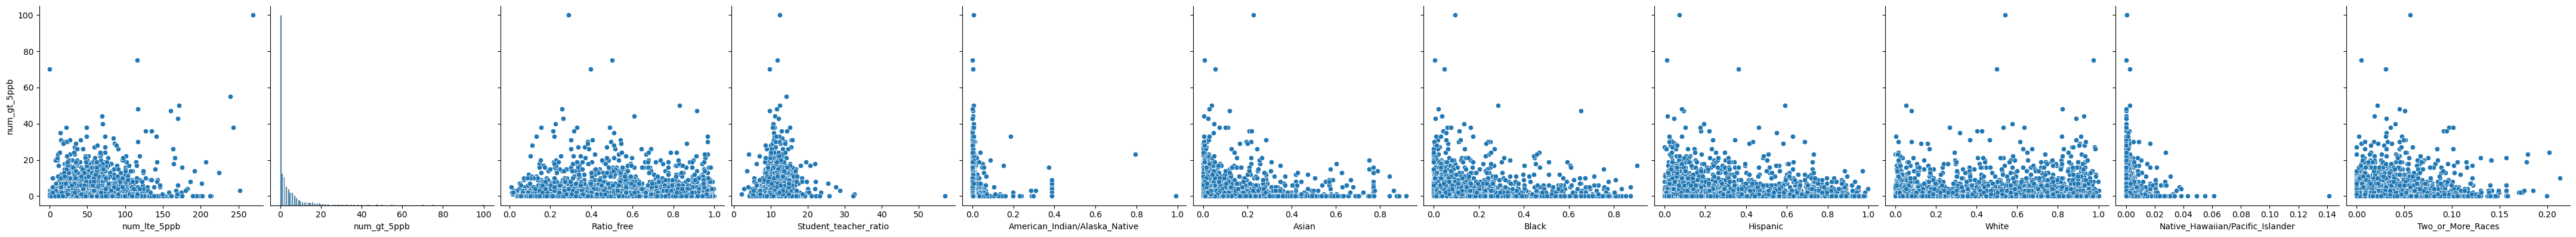

In [ ]:
sns.pairplot(df_copied,x_vars=numeric_cols,y_vars=['num_gt_5ppb'], height=4)
plt.show()

# Identify Important Features

### Box plot
We note that the median values for Ratio_free and Whites are well separated. For other features, there are a lot of outliers

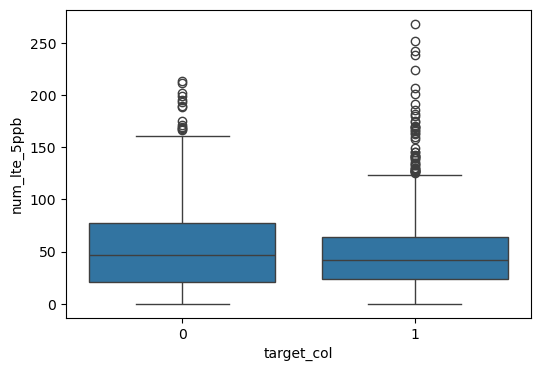

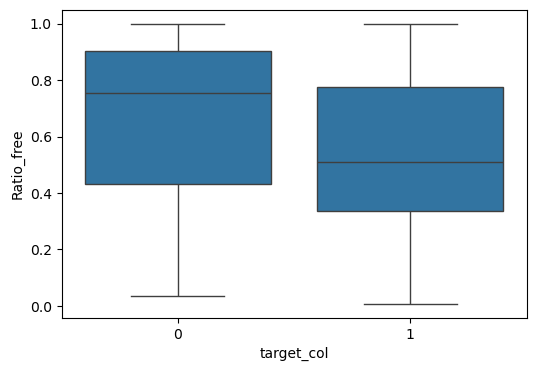

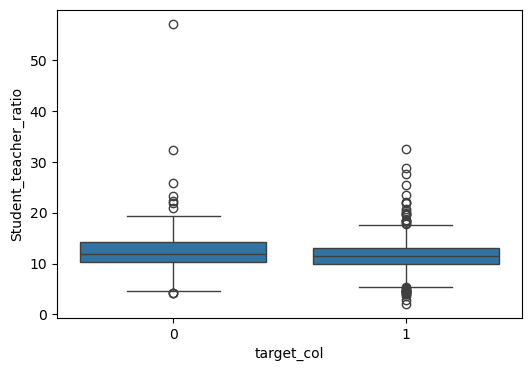

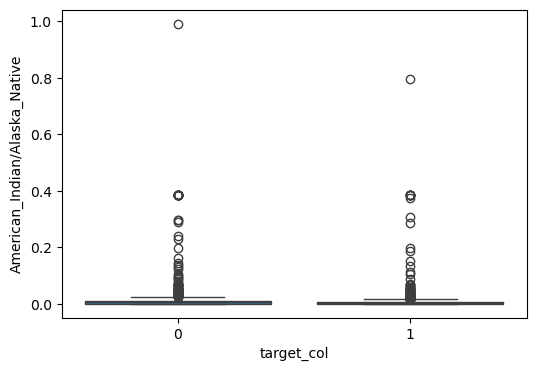

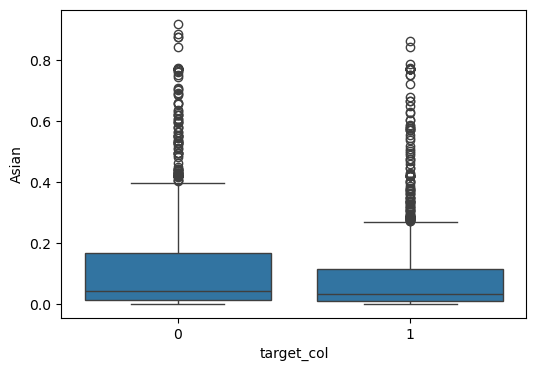

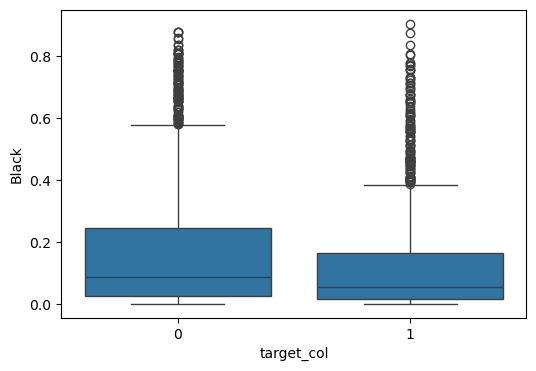

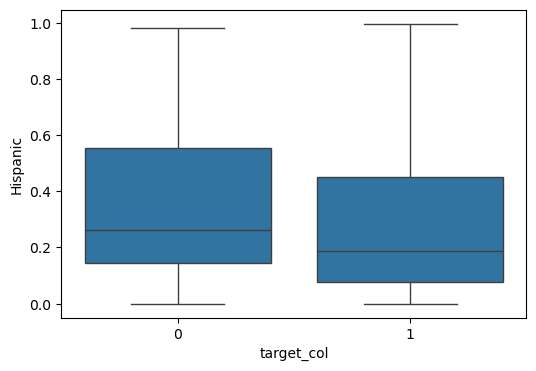

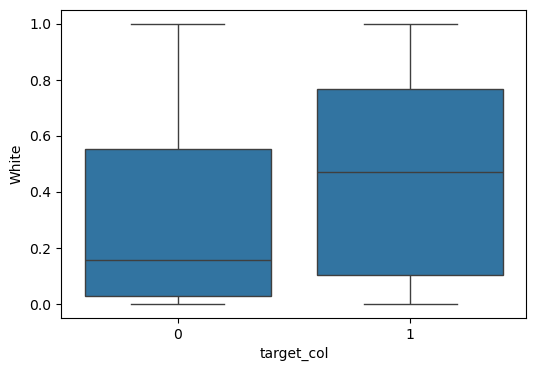

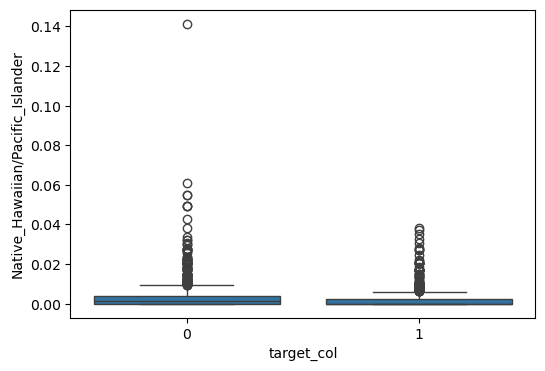

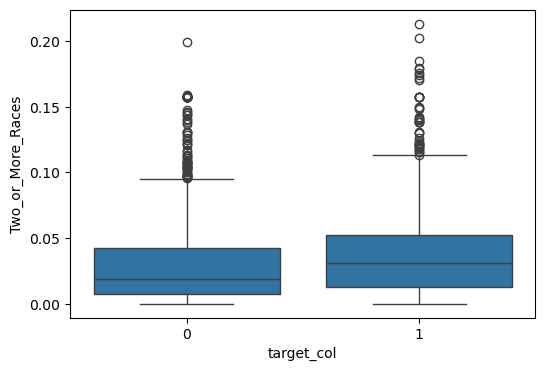

In [ ]:
for col in numeric_cols:
    if col != 'num_gt_5ppb':
        plt.figure(figsize=(6,4))
        sns.boxplot(x='target_col', y=col, data=df_copied)
        plt.show()


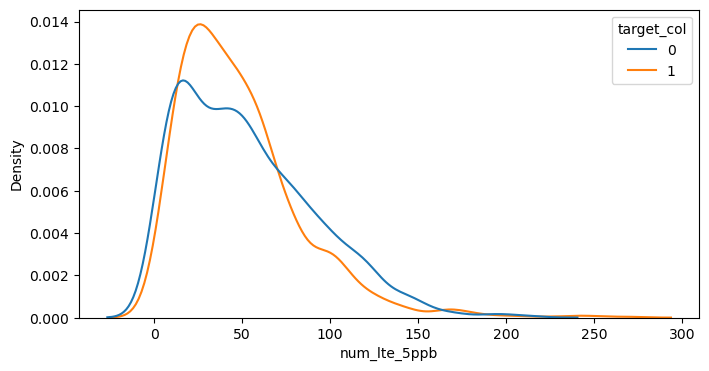

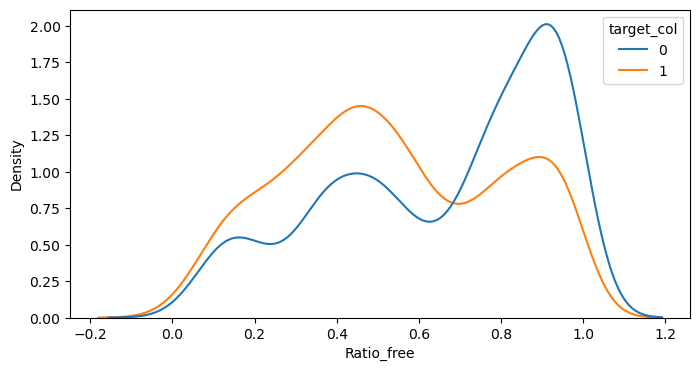

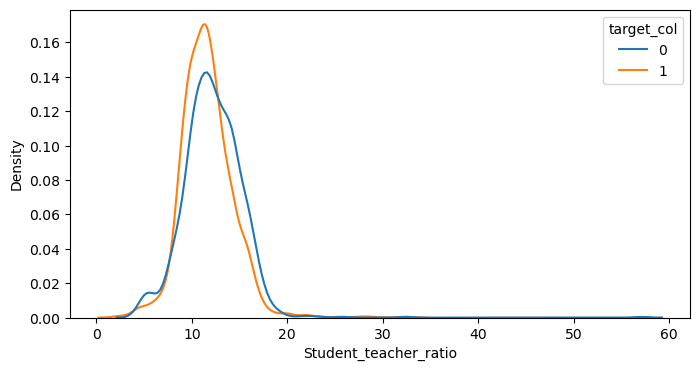

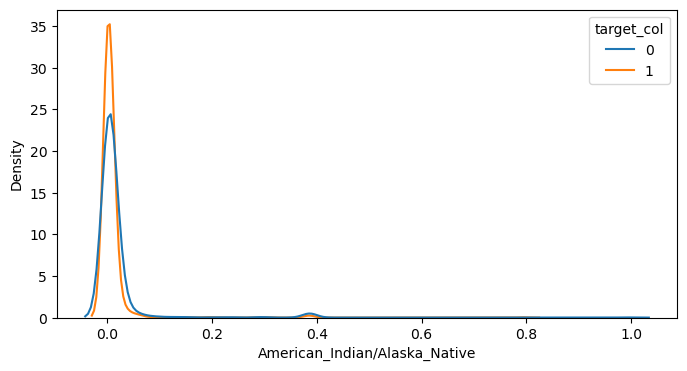

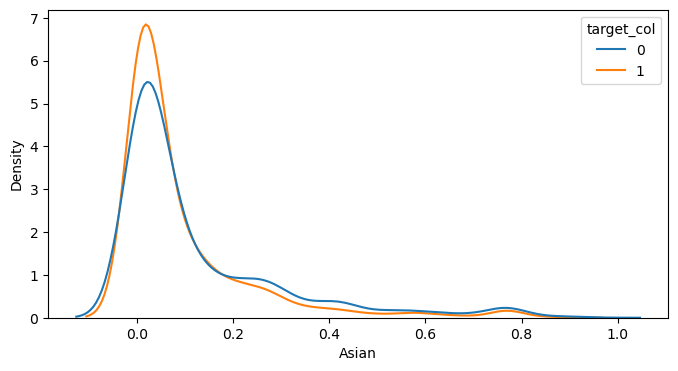

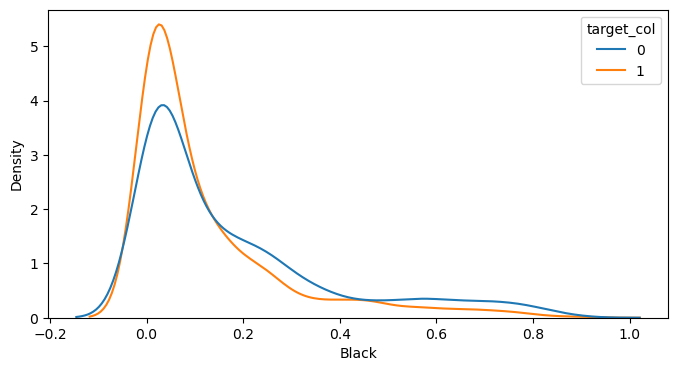

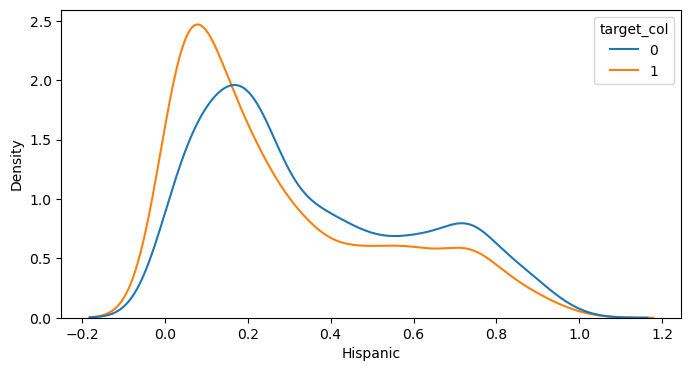

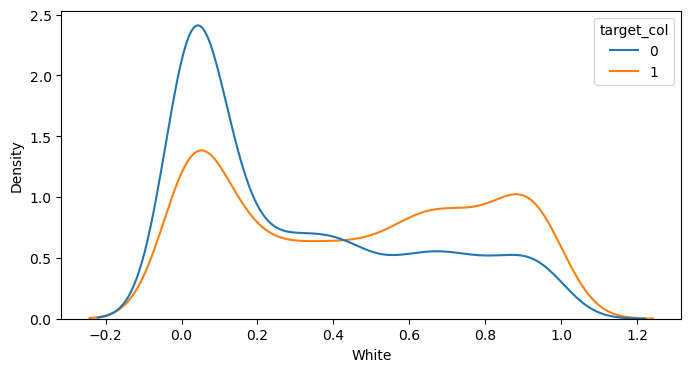

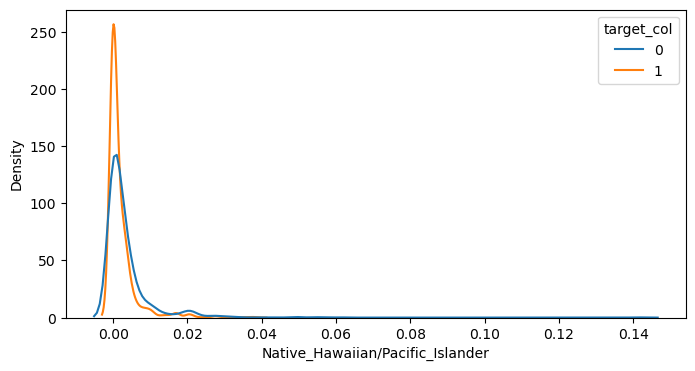

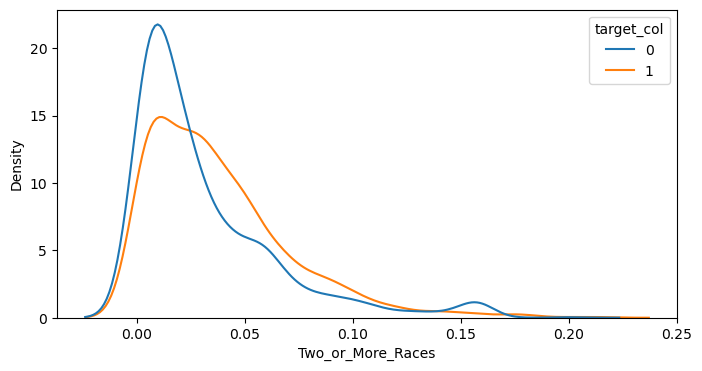

In [ ]:
for col in numeric_cols:
    if col != 'num_gt_5ppb':  # skip target count
        plt.figure(figsize=(8,4))
        sns.kdeplot(data=df_copied, x=col, hue='target_col', common_norm=False)
        plt.show()


In [ ]:
df_copied.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2929 entries, 0 to 2928
Data columns (total 16 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   School_District                   2928 non-null   object 
 1   School                            2929 non-null   object 
 2   County                            2929 non-null   object 
 3   num_lte_5ppb                      2922 non-null   float64
 4   num_gt_5ppb                       2922 non-null   float64
 5   School_City                       2929 non-null   object 
 6   Ratio_free                        2678 non-null   float64
 7   Student_teacher_ratio             2757 non-null   float64
 8   American_Indian/Alaska_Native     2678 non-null   float64
 9   Asian                             2678 non-null   float64
 10  Black                             2678 non-null   float64
 11  Hispanic                          2678 non-null   float64
 12  White 

In [ ]:
df_copied.to_csv('Lead_eda.csv',index=False)

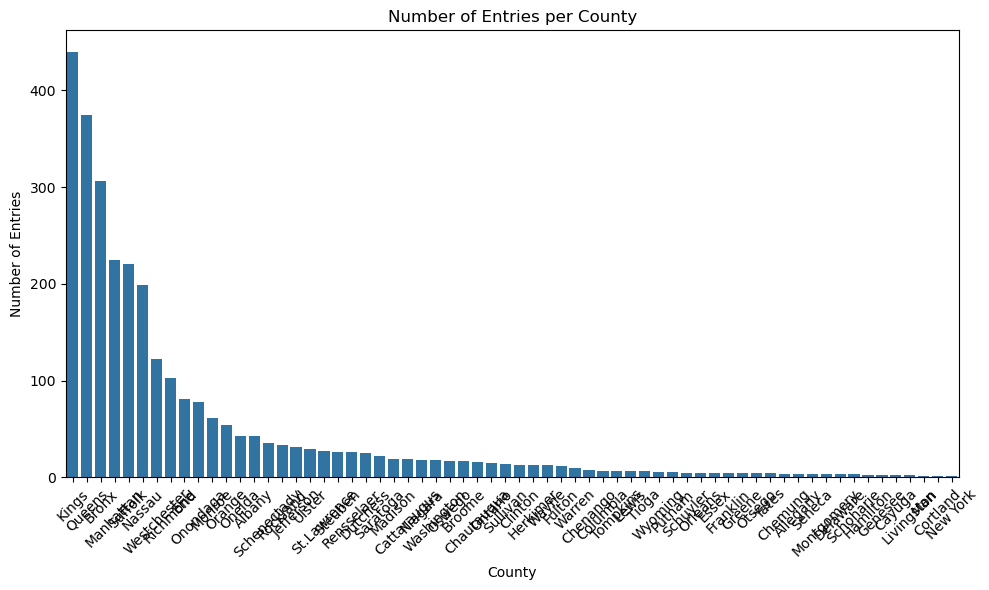

In [ ]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df_copied, x='County', order=df_copied['County'].value_counts().index)

plt.xlabel('County')
plt.ylabel('Number of Entries')
plt.title('Number of Entries per County')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
df_copied.School_City.value_counts()

,count
School_City,
Brooklyn,277
Queens,246
Bronx,189
BROOKLYN,163
Manhattan,141
...,...
WHITESVILLE,1
ANDOVER,1
WEST LEYDEN,1


In [ ]:
df_copied.School_District.value_counts()

,count
School_District,
NYC DOE,1450
BUFFALO CITY SCHOOLS,46
SYRACUSE CITY SCHOOLS,35
SCHENECTADY CITY SCHOOLS,17
GREECE CENTRAL SCHOOL,16
...,...
BOLTON CENTRAL SCHOOL,1
WORCESTER CENTRAL SCHOOL,1
WILLSBORO CENTRAL SCHOOL,1


In [ ]:
df_copied.County.value_counts()

,count
County,
Kings,440
Queens,375
Bronx,306
Manhattan,225
Suffolk,220
...,...
Genesee,2
Cayuga,2
Cortland,1


#  Percentage (%) of Schools with Lead Over 5ppb, by County

/tmp/ipython-input-1203903313.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=county_summary.index, y=county_summary['Proportion_Exceedance'], palette='viridis')


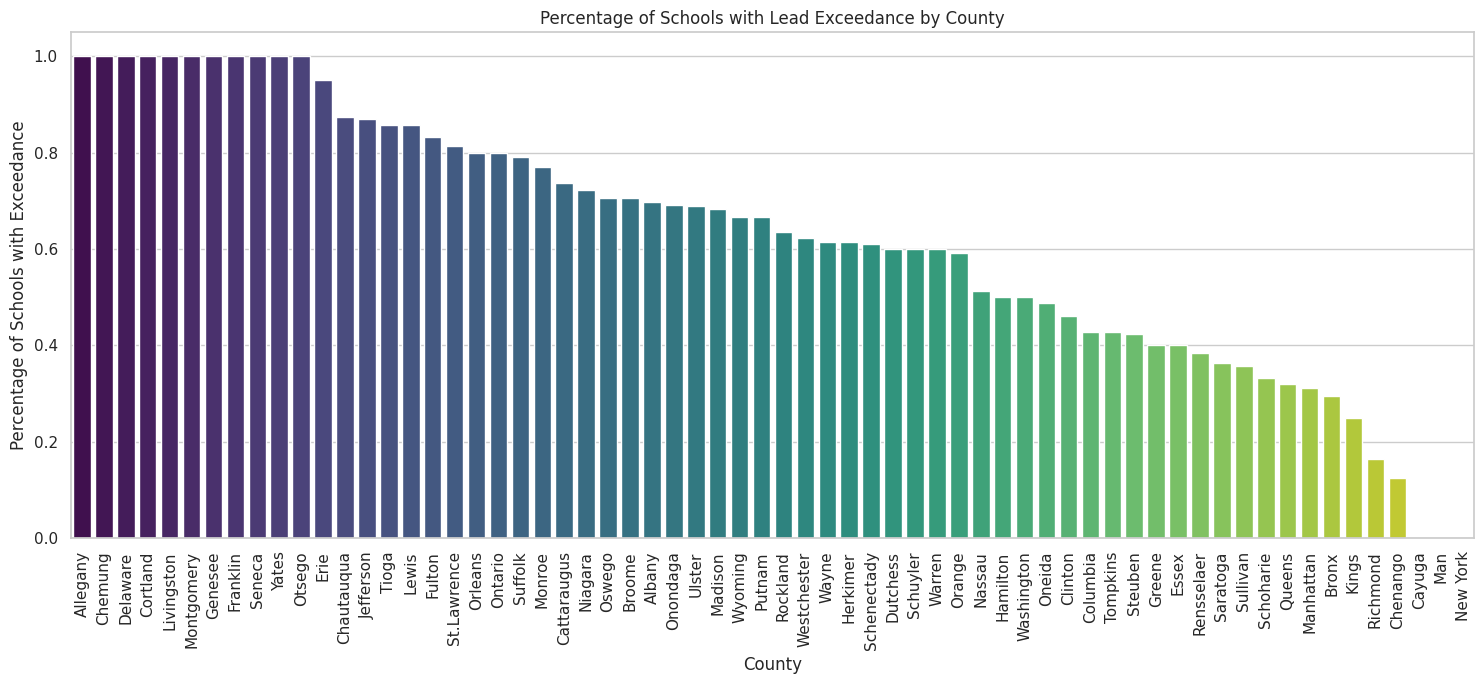

In [ ]:
# Add a column to indicate if a school has lead exceedance
df['Has_Lead_Exceedance'] = df['Number of Outlets, Result > 5 ppb'] > 0

# Group by County and calculate the proportion of schools with lead exceedance
county_summary = df.groupby('County')['Has_Lead_Exceedance'].value_counts(normalize=True).unstack().fillna(0)

# Rename columns for clarity
county_summary.columns = ['Proportion_No_Exceedance', 'Proportion_Exceedance']

# Sort by the proportion of schools with exceedance in descending order
county_summary = county_summary.sort_values('Proportion_Exceedance', ascending=False)

plt.figure(figsize=(15, 7))
sns.barplot(x=county_summary.index, y=county_summary['Proportion_Exceedance'], palette='viridis')
plt.title('Percentage of Schools with Lead Exceedance by County')
plt.xlabel('County')
plt.ylabel('Percentage of Schools with Exceedance')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [ ]:
# Add a column to indicate if a school has lead exceedance
df['Has_Lead_Exceedance'] = df['Number of Outlets, Result > 5 ppb'] > 0

# Group by County and calculate the proportion of schools with lead exceedance
county_summary = df.groupby('County')['Has_Lead_Exceedance'].value_counts(normalize=True).unstack().fillna(0)

# Rename columns for clarity
county_summary.columns = ['Proportion_No_Exceedance', 'Proportion_Exceedance']

# Sort by the proportion of schools with exceedance in descending order
county_summary = county_summary.sort_values('Proportion_Exceedance', ascending=False)

# Demographics of Erie County

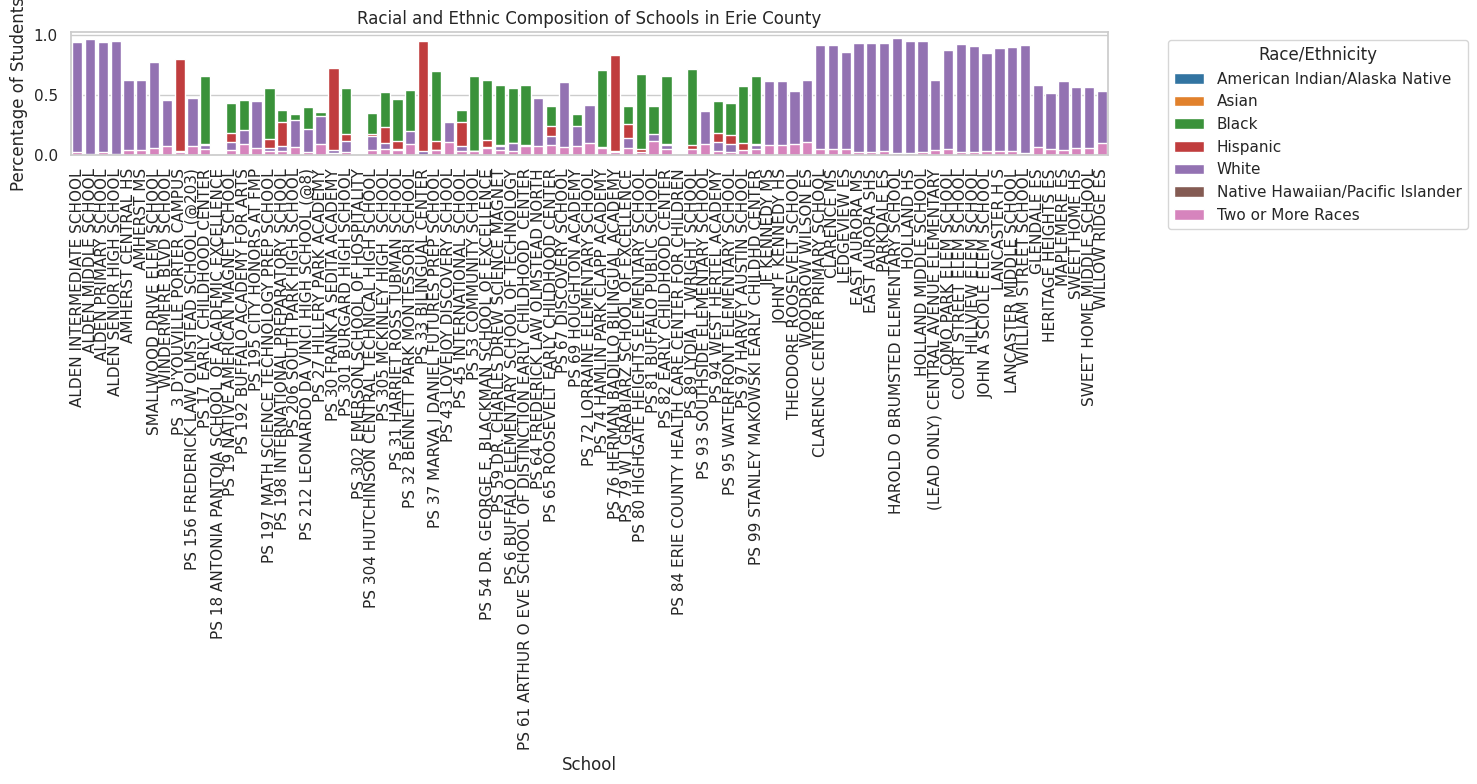

In [ ]:
# Filter the dataframe for schools in Erie County
erie_county_schools = df[df['County'] == 'Erie'].copy()

# Select the racial/ethnic percentage columns
racial_ethnic_cols = [
    'American Indian/Alaska Native', 'Asian', 'Black', 'Hispanic', 'White',
    'Native Hawaiian/Pacific Islander', 'Two or More Races'
]

# Melt the dataframe to a long format for plotting
erie_county_melted = erie_county_schools.melt(
    id_vars='School',
    value_vars=racial_ethnic_cols,
    var_name='Race/Ethnicity',
    value_name='Percentage'
)

# Create the stacked bar chart
plt.figure(figsize=(15, 8))
sns.barplot(
    data=erie_county_melted,
    x='School',
    y='Percentage',
    hue='Race/Ethnicity',
    palette='tab10',
    dodge=False # This creates the stacked effect
)

plt.title('Racial and Ethnic Composition of Schools in Erie County')
plt.xlabel('School')
plt.ylabel('Percentage of Students')
plt.xticks(rotation=90)
plt.legend(title='Race/Ethnicity', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Correlation between Race and Excedance of Lead Over 5ppb

In [ ]:
# Select racial/ethnic columns and the County column
racial_ethnic_cols = [
    'County',
    'American Indian/Alaska Native', 'Asian', 'Black', 'Hispanic', 'White',
    'Native Hawaiian/Pacific Islander', 'Two or More Races'
]
df_racial_county = df[racial_ethnic_cols]

# Calculate the average racial/ethnic percentage per county
average_racial_per_county = df_racial_county.groupby('County')[racial_ethnic_cols[1:]].mean().reset_index()

# Merge with the county_summary dataframe
county_correlation_data = pd.merge(county_summary, average_racial_per_county, on='County', how='left')

# Calculate the correlation matrix, excluding the non-numeric 'County' column
correlation_matrix = county_correlation_data.drop('County', axis=1).corr()

# Display the correlations of 'Proportion_Exceedance' with racial/ethnic columns
display(correlation_matrix[['Proportion_Exceedance']].drop('Proportion_Exceedance'))

,Proportion_Exceedance
Proportion_No_Exceedance,-1.000000
American Indian/Alaska Native,-0.130574
Asian,-0.285811
Black,-0.395123
Hispanic,-0.390024
White,0.437091
Native Hawaiian/Pacific Islander,-0.453221
Two or More Races,-0.016207


#  Top 10 Counties with Lead Exceedance

In [ ]:
# Group by County and calculate the proportion of schools with lead exceedance
county_exceedance_summary = df.groupby('County')['Has_Lead_Exceedance'].value_counts(normalize=True).unstack().fillna(0)

# Rename columns for clarity
county_exceedance_summary.columns = ['Proportion_No_Exceedance', 'Proportion_With_Exceedance']

# Sort by the proportion of schools with exceedance in descending order
county_exceedance_summary = county_exceedance_summary.sort_values('Proportion_With_Exceedance', ascending=False)

# Select the top 10 counties with the highest proportion of schools with lead exceedance
top_counties = county_exceedance_summary.head(10).index.tolist()

# Filter the original dataframe to include only schools in the top counties
top_counties_df = df[df['County'].isin(top_counties)].copy()

# Display the first few rows of the filtered dataframe to see the data
display(top_counties_df.head())

,Compliance Period,School District,School,County,Type of Organization,BEDS Code,School Website,Number of Outlets that Require Sampling,Number of Outlets Sampled 2023,Number of Outlets Sampled 2024,...,Black,Hispanic,White,Native Hawaiian/Pacific Islander,Two or More Races,lead_over_5ppb,lead_outlet_count,county_norm,fips5,Has_Lead_Exceedance
17,2023-2025,ALFRED ALMOND CENTRAL SCHOOL DISTRICT,ALFRED-ALMOND JUNIOR-SENIOR HIGH SCHOOL (and E...,Allegany,Public School,20101040002,https://www.aacsapps.com/site/default.aspx?Pag...,54.0,54.0,54.0,...,0.007491,0.052434,0.883895,0.000000,0.029963,1,6,allegany,2023-2025,True
26,2023-2025,ANDOVER CENTRAL SCHOOL DISTRICT,ANDOVER CENTRAL SCHOOL,Allegany,Public School,20601040001,www.andovercsd.org,19.0,97.0,19.0,...,NaN,NaN,NaN,NaN,NaN,1,1,allegany,2023-2025,True
142,2023-2025,BRUSHTON-MOIRA CENTRAL SCHOOL,BRUSHTON-MOIRA CENTRAL SCHOOL,Franklin,Public School,161601040003,https://www.bmcsd.org/,116.0,0.0,116.0,...,0.008621,0.010776,0.946121,0.000000,0.019397,1,9,franklin,2023-2025,True
194,2023-2025,CANAJOHARIE CENTRAL SCHOOL,CANAJOHARIE MIDDLE SCHOOL,Montgomery,Public School,270301040003,https://www.canajoharieschools.org/,27.0,0.0,27.0,...,0.000000,0.021978,0.945055,0.005495,0.027473,1,1,montgomery,2023-2025,True
195,2023-2025,CANAJOHARIE CENTRAL SCHOOL,CANAJOHARIE S H S,Montgomery,Public School,270301040002,https://www.canajoharieschools.org/,34.0,0.0,34.0,...,0.015152,0.000000,0.965909,0.000000,0.011364,1,1,montgomery,2023-2025,True
